In [2]:
import sys
from pathlib import Path

parent = str(Path().resolve().parent)
if parent not in sys.path:
    sys.path.insert(0, parent)

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import networkx as nx
from itertools import combinations
import ast

We can project our bipartite network in two ways: The musicians as nodes connected by common music groups and vice versa.

In our network analysis, we will mainly focus on the Danish Music Groups (DMG) projection of the network connected by common musicians to narrow the scope and enable a more in-depth exploration. The musicians network has an interpretation problem as nodes with a high degree are hard to interpret. High-degree musicians can both be associated with multiple music groups or just be a musician of a very large music group (ex a symphony orchestra). This is also an influence in the DMG projection, however here a group also has to share musicians with other groups to create a link and thereby the large music groups does not automatically create many links. Lastly, very few musicians (of famous bands even) don’t have a wikipedia article, although fairly unknown bands have. Thereby it is natural to focus on music groups, which also will be the focus of our text analysis.

In [4]:
with open("../data/wip/groups_graph.pkl", "rb") as f:
    G = pickle.load(f)

We calculate the probability (p) average degree (k) of the network 
ref[Section 3.2, equation (3.2) in Network Science, Albert-Laszlo Barabasi]

In [5]:
N = G.number_of_nodes()
L = G.number_of_edges()

p = L / ((N*(N-1))/2)  # for undirected graphs, we divide by 2

k = p*(G.number_of_nodes() - 1)

print(f"Size of network: {N}")
print(f"Probability: {p}")
print(f"Average degree: {k}")

Size of network: 814
Probability: 0.0016772895001677288
Average degree: 1.3636363636363635


The average degreee is 1.36, so on average a music group is sharing a musican with 1.36 other music groups.


Now, we write a function to generate a Random Network (RN) that mirrors DMG in terms of node count, using your calculated p. We generate the random network by linking nodes in every possible pair with probability.

In [6]:
def random_network(N,p):
    
    #Start with N isolated nodes.
    R = nx.Graph()
    R.add_nodes_from(range(N))

    #Select a node pair and generate a random number between 0 and 1
    for u in range(N):
        for v in range(u+1,N):
            if np.random.rand() < p: #If the number exceeds p:
                R.add_edge(u,v) #connect the selected node pair with a link, otherwise leave them disconnected.
    return R

F = random_network(N,p)

In [7]:
# Function to visualize the graph F and G in one figure
def plot_2graphs(G, F):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)

    plt.title("Random Network")
    plt.axis('off')
    pos = nx.spring_layout(F)
    nx.draw(F, pos, node_size=10, node_color='blue', alpha=0.5, width=0.2)
    plt.subplot(1, 2, 2)
    plt.title("Original Network")
    plt.axis('off')
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=10, node_color='red', alpha=0.5, width=0.2)
    plt.show()

def scatter_dist(G, F):
    def get_deg_dist(graph):
        degree_dict = dict(graph.degree())
        return np.unique(list(degree_dict.values()), return_counts=True)

    # Get degree distributions
    degs_G, counts_G = get_deg_dist(G)
    degs_F, counts_F = get_deg_dist(F)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(degs_G, counts_G, s=20, alpha=0.7, label='DMG Network', color='blue')
    plt.scatter(degs_F, counts_F, s=20, alpha=0.3, label='Random Network', color='red')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degree", fontsize=12)
    plt.ylabel("Nodes with degree count", fontsize=12)
    plt.title("Degree Distribution DMG Network (Log-Log)", fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.3)
    plt.show()

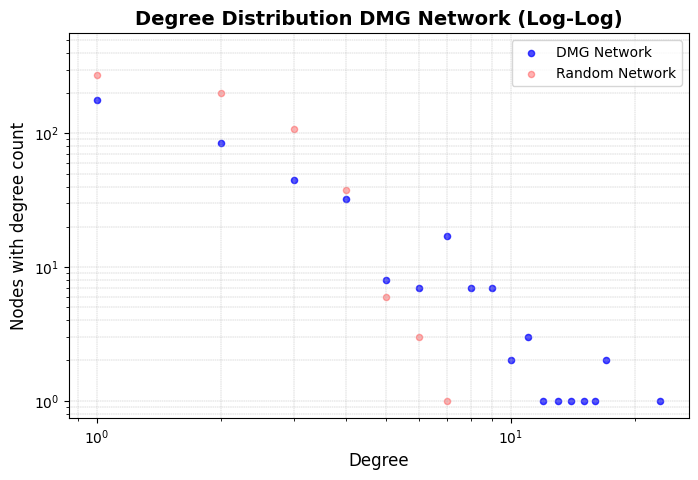

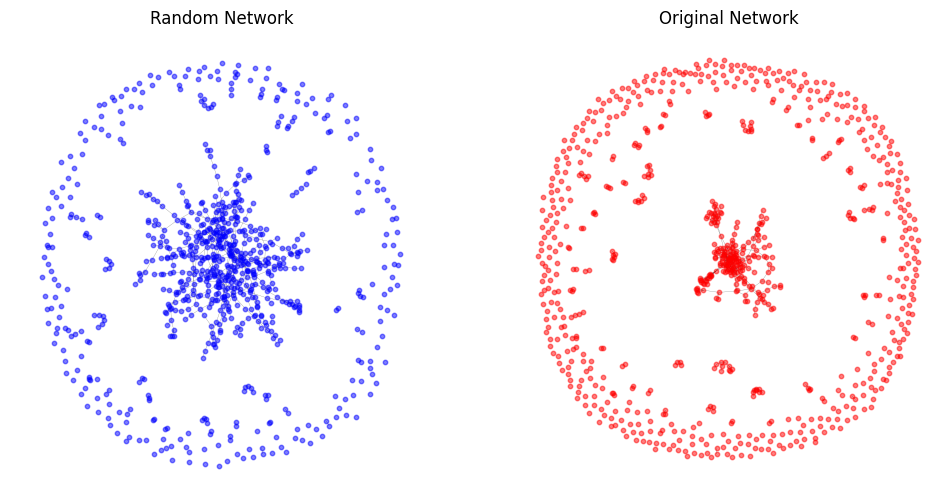

In [8]:
scatter_dist(G, F)

plot_2graphs(G, F)

The degree destribution scatter plot suggests that our network follows a heavy tail distribution, as it in a log-log plot nearly follows the diagonal in contrast to the random network. Also, potential hub nodes emerges in the right corner of the plot.

In [9]:
hubnodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]
hubnodes

[('Kansas City Stompers', 23),
 ('Frede Fup', 17),
 ('Lone Kellermann og Rockbandet', 17),
 ('Delta Cross Band', 16),
 ('Gorilla Angreb', 15)]

In the network plot, we see a diffence between the networks. The random network is not fully connected but is in the supercritical regime as k = 1.36 > 1. The DMG network has more disconected nodes and more connected center which corresponds to the scatter plot. It seems resonable that it has more disconnected nodes as it is natural that bands never break up and share musicians with other music groups. To investigate the very connected center, we will try to look only at the giant component.

In [10]:
G_components = nx.connected_components(G)
G_largest_component = max(G_components, key=len)
G_giant = G.subgraph(G_largest_component)


F_components = nx.connected_components(F)
F_largest_component = max(F_components, key=len)
F_giant = F.subgraph(F_largest_component)

G_giantN = G_giant.number_of_nodes()
G_giantp = G_giant.number_of_edges() / ((G_giantN*(G_giantN-1))/2)

F_giantN = F_giant.number_of_nodes()
F_giantp = F_giant.number_of_edges() / ((F_giantN*(F_giantN-1))/2)

print(f"Size of giants (DMG,RN): {G_giantN, F_giantN}")
print(f"Average degrees (DMG,RN): {G_giantp*(G_giantN - 1), F_giantp*(F_giantN - 1)}")

Size of giants (DMG,RN): (202, 481)
Average degrees (DMG,RN): (4.0, 2.0956340956340958)


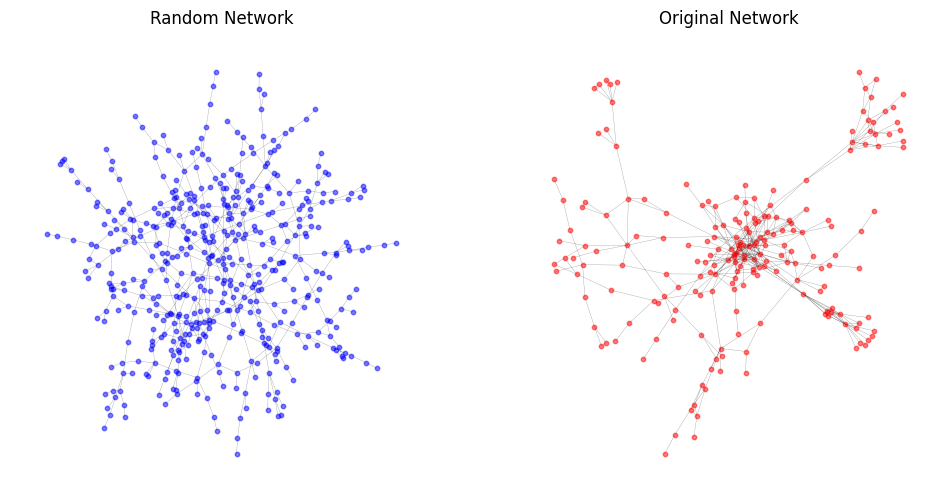

In [11]:
plot_2graphs(G_giant, F_giant)

Looking at the plot, the DMG network does not appear random. This encourage us to investigate possible communities, degree distribution and small world property.

### Small-world property

We will in this section look at the giant component, which somewhat corresponds to the largest community of connected

In [12]:
# Calculate the average shortest path length within the giant:
shortest_G = nx.average_shortest_path_length(G_giant,None)
shortest_F = nx.average_shortest_path_length(F_giant,None)

print(f"Average shortest path length for the giant in RN: {shortest_F}")
print(f"Average shortest path lenght for the giant in DMG: {shortest_G}")

Average shortest path length for the giant in RN: 12.964414414414414
Average shortest path lenght for the giant in DMG: 5.588788729619231


In [13]:
clustering_G = nx.average_clustering(G_giant)
clustering_F = nx.average_clustering(F_giant)

print(f"Clustering coefficient for the giant in RN: {clustering_F}")
print(f"Clustering coefficient for the giant in DMG: {clustering_G}")

Clustering coefficient for the giant in RN: 0.006029106029106029
Clustering coefficient for the giant in DMG: 0.30503920730174816


The DMG giant has an average shortest path of 5.5, which means that, on average, there is a maximum of around six links between two music groups. This is more than half the average shortest path in the random network. This is an atypical result ($L_{real}$ > $L_{random}$) and might be due to few highly musician sharing groups - hub nodes (one potential hub nodes discovered below the scatter plot). However this might not exclude that the network may still have small-world properties. The clustering coefficients indicate significantly higher clustering than the random network, which is a key characteristic of small-world networks. All togehter, this suggests that the DMG network, may possess small-world characteristics.

It is a very interesting insight. The bands in the giant tend to cluster strongly and might have hub tendencies. To follow up, we will now try to understand the character of the clusters in network.

### Assortiativity

In [14]:
assortativity_G = nx.degree_assortativity_coefficient(G)
assortativity_F = nx.degree_assortativity_coefficient(F)

print(f"Assortativity coefficient for RN: {assortativity_F}")
print(f"Assortativity coefficient for the DMG network: {assortativity_G}")

Assortativity coefficient for RN: 0.00697701826753096
Assortativity coefficient for the DMG network: 0.36265932035036547


In [15]:
nx.attribute_assortativity_coefficient(G, "genre")

/home/marcus/Documents/Computational social science/.venv/lib/python3.12/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)


nan

So, the DMG network has a high assortiativity, which suggest that high-degree music groups are more likely to connect to other high-degree groups. This may suggest genre-based clustering.

To examine the categorical assortativity using genre, we have to take into account that groups have assigned multiple non-sorted genres. This means we might have to use similarities of the genres between two music groups to get a satisfactorily interpretable result. For this we use jaccard similarity. However, this is now formally not a assortativity measure as a jaccard similarity ranges from 0 to 1. Thereby the average jaccard between linked nodes will also have the same range. So:

Average similarity = 0: All connected music groups has different genres.\
Average similarity = 1: All connected music groups has the same set of genres.

In [16]:
df_groups = pd.read_csv("../data/wip/groups_wMembers_Text_Genres.csv")

genres_dict = dict(zip(df_groups["title"], df_groups["genres"]))

nx.set_node_attributes(G, genres_dict, name="genre")

In [17]:
def g2set(g1_raw):
    # Convert string to actual list if needed
    if isinstance(g1_raw, str):
        try:
            g1 = ast.literal_eval(g1_raw)
        except (ValueError, SyntaxError):
            g1 = []
    else:
        g1 = g1_raw  # Already a list

    return set(map(str.strip, g1))

def genre_overlap(g1, g2):
    set1 = g2set(g1)
    set2 = g2set(g2)
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) else 0 # Jaccard similarity

# Average genre similarity across all edges
total = 0
count = 0
for u, v in G.edges():
    genre_u = G.nodes[u].get("genre")
    genre_v = G.nodes[v].get("genre")
    if genre_u and genre_v:
        sim = genre_overlap(genre_u, genre_v)
        total += sim
        count += 1

avg_similarity = total / count if count else 0
print(f"Average genre similarity between connected groups: {avg_similarity}")

Average genre similarity between connected groups: 0.3297848127457068


In [18]:
# for comparison, we can also calculate the average genre similarity for all nodes:
total_sim = 0
count = 0

for u, v in combinations(G.nodes(), 2):  # All unique pairs
    genre_u = G.nodes[u].get("genre")
    genre_v = G.nodes[v].get("genre")

    if genre_u and genre_v:
        sim =  genre_overlap(genre_u, genre_v)
        total_sim += sim
        count += 1

avg_global_jaccard = total_sim / count if count else 0
print(f"Average global Jaccard similarity (all node pairs): {avg_global_jaccard}")

Average global Jaccard similarity (all node pairs): 0.11096519585046614


/tmp/ipykernel_8555/1966013528.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


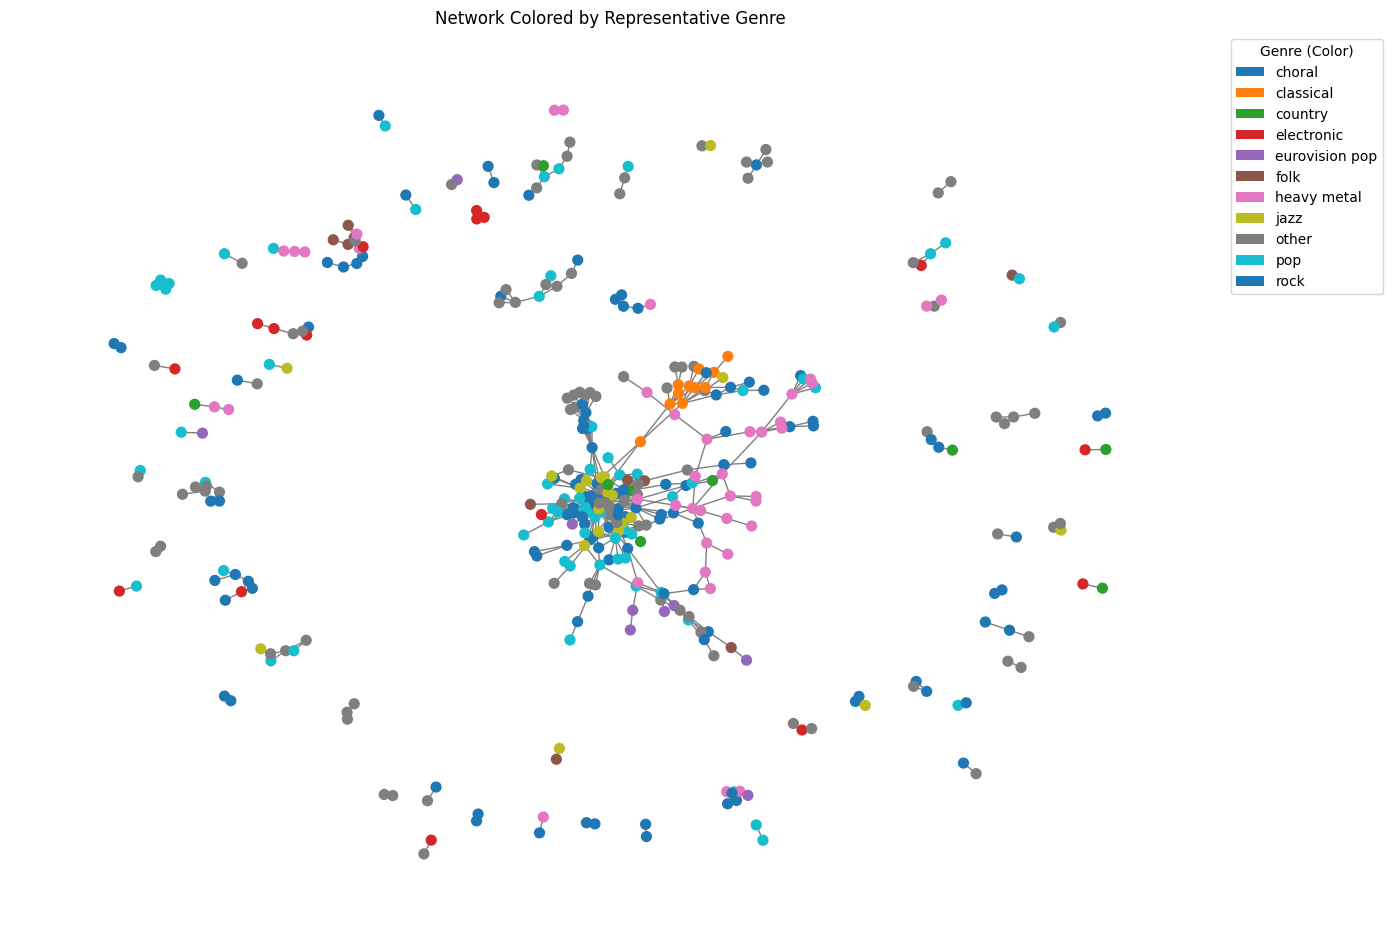

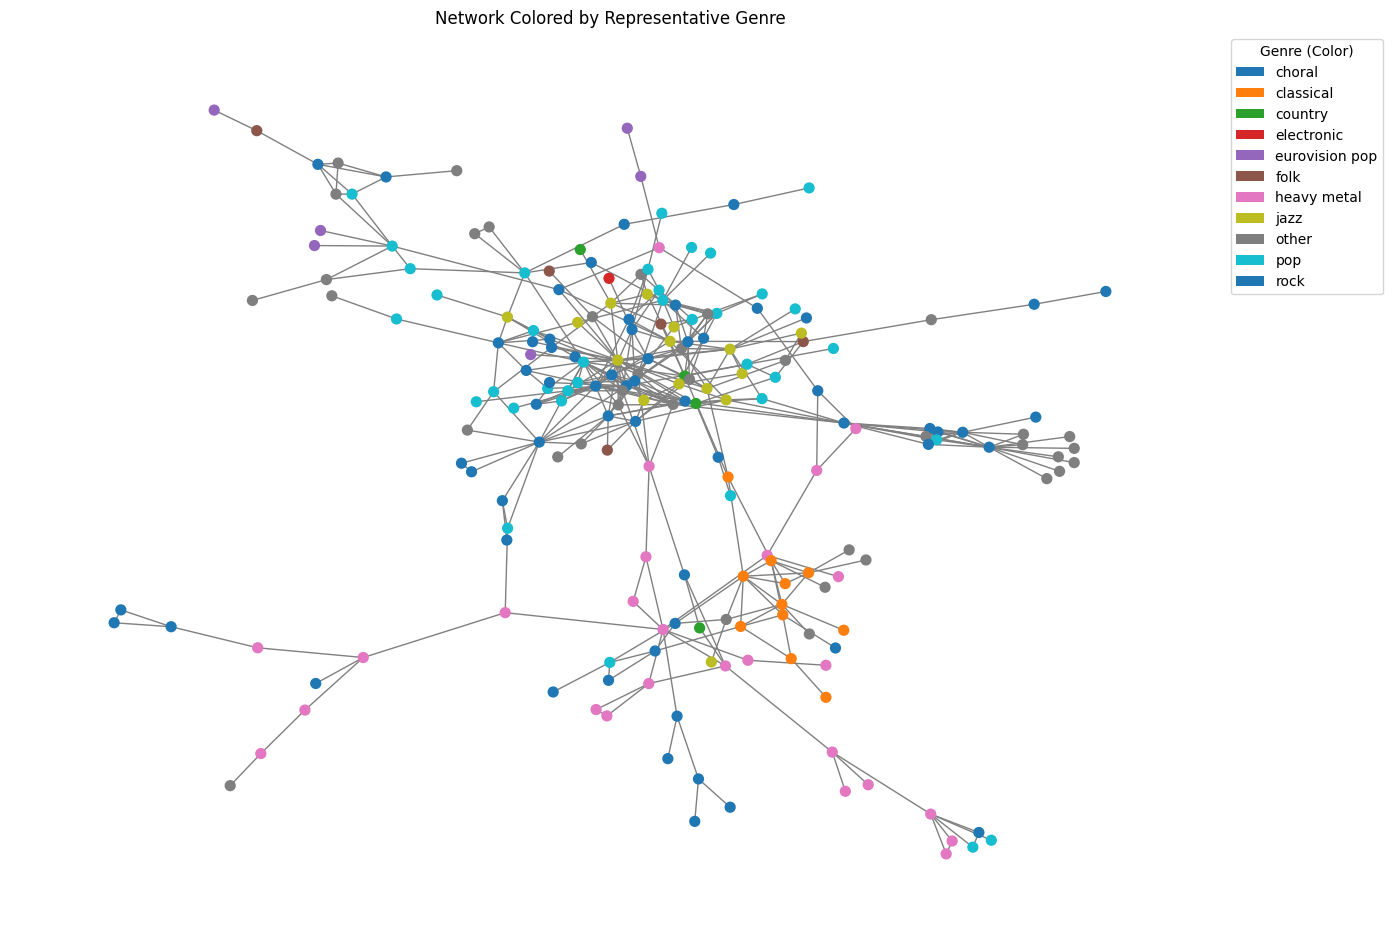

In [19]:
groupsG = G.copy()
groupsG.remove_nodes_from(list(nx.isolates(groupsG)))


def plotNetwork_color(G):
    #Genre hierarchy
    hierarchy = ["eurovision pop", "jazz", "choral", "classical", "heavy metal", "country", "electronic", "folk" , "pop", "rock"]
    # the hierarchy is defined in a way that the most common genres pop and rock are at the end of the list

    def pick_genre(genres_raw):
        if isinstance(genres_raw, str):
            try:
                genres = ast.literal_eval(genres_raw)
            except (ValueError, SyntaxError):
                genres = []
        else:
            genres = genres_raw or []

        genres_lower = [g.lower().strip() for g in genres]

        for genre in hierarchy:
            if genre in genres_lower:
                return genre
        return "other"


    genre_map = {node: pick_genre(G.nodes[node].get("genre")) for node in G.nodes()}


    unique_genres = sorted(set(genre_map.values()))

    color_map = {genre: plt.cm.tab10(i % 10) for i, genre in enumerate(unique_genres)}

    #NOTE: is the right genre swapped??
    color_map["other"], color_map["jazz"] = color_map["jazz"], color_map["other"]

    node_colors = [color_map[genre_map[node]] for node in G.nodes()]


    # Plot the graph
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 9))

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=False,
        node_size=50,
        edge_color='gray'
    )

    # Create a legend as a table
    legend_elements = [Patch(facecolor=color_map[genre], label=genre) for genre in unique_genres]
    plt.legend(handles=legend_elements, title="Genre (Color)", loc="upper right", bbox_to_anchor=(1.15, 1.0))

    plt.title("Network Colored by Representative Genre")
    plt.tight_layout()
    plt.show()

plotNetwork_color(groupsG)
plotNetwork_color(G_giant)

From the similarity average and global similarity average we se a significantly higher similarity between connected nodes. So, music groups more often link with music groups with similar sets of genres. This indicates that communities tend to share the same genres, which makes sense as a rock musician might no be able to play in a classical orcestra also. Looking at the colored plot of the giant of the DMG network, we see an isolated cluster in the buttom consisting mostly of the genres "classical" and "choral", which are rather similar genres. In the very connected middle the genres "rock", "pop" and "jazz" seem to be dominant.

### Centrality

It can also be interesting to look at the centrality of nodes. Does this hub nodes earlier found connect with eachother to create "super hubs"? 

In [20]:
# Compute Eigen centrality for the giant component of the musicians network
eigen_centrality_G = nx.eigenvector_centrality(G)

top_10_G = sorted(eigen_centrality_G.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by Eigen centrality in the DMG network:")
print("")
for node, centrality in top_10_G:
    print(f"{node} - Centrality: {centrality:.4f}")
print("")
print(hubnodes)

Top 10 nodes by Eigen centrality in the DMG network:

Lone Kellermann og Rockbandet - Centrality: 0.3162
Kansas City Stompers - Centrality: 0.3152
Frede Fup - Centrality: 0.3108
Kim Larsen & Bellami - Centrality: 0.2907
Delta Cross Band - Centrality: 0.2784
Starfuckers - Centrality: 0.2643
På Slaget 12 - Centrality: 0.2056
Skousen & Ingemann - Centrality: 0.2055
Røde Mor - Centrality: 0.1972
Culpeper's Orchard - Centrality: 0.1899

[('Kansas City Stompers', 23), ('Frede Fup', 17), ('Lone Kellermann og Rockbandet', 17), ('Delta Cross Band', 16), ('Gorilla Angreb', 15)]


In [21]:
ex = df_groups[(df_groups["title"] == "Kansas City Stompers") | 
               (df_groups["title"] == "Lone Kellermann og Rockbandet")]

ex["cleaned_member"].values

array(["['Lone Kellermann', 'Bjørn Uglebjerg', 'Joachim Ussing', 'Ivan Horn', 'Thomas Grue', 'Nils Henriksen', 'Wili Jønsson', 'Billy Cross']",
       "['Niels Abild', 'Åke Gram', 'Alex Riel', 'Bent Clausen', 'Bo Stief', 'Finn Ziegler', 'Gert Rostock Jensen', 'Gunhild Carling', 'Hans Åsberg', 'Hans Fagt', 'Hans Verner Ottesen', 'Hugo Rasmussen', 'Jacob Andersen', 'Jan Glæsel', 'Jan Hem', 'Jens Haack', 'Jens Melgaard', 'Jesper Lundgaard', 'John Kaas Ibsen', 'Johnny Goffy Rasmussen', 'Karsten Kristensen', 'Kenneth Agerholm', 'Kurt Riedel', 'Lennart Flindt', 'Lennart Gruvstedt', 'Niels Bødker', 'Niels Olsen', 'Niels Ratzer', 'Niels Stuart', 'Nils Henriksen', 'Nils Rehman', 'Nynne Lange', 'Ole Berg', 'Ole Hansen', 'Ole Kock Hansen', 'Ole Ousen', 'Ole Skipper Mosgaard', 'Palle Bremer Nielsen', 'Peder Kragerup', 'Pelle Thomsen', 'Per Carsten Petersen', 'Søren Fechtenberg', 'Steen Hansen', 'Svend Baaring', 'Svend-Erik Nørregaard', 'Torben Hertz', 'Torben Munk', 'Ulf Johansson Werre', 'Verner 

The "Kansas City Stompers" is much larger band than the "Lone Kellermann og Rockbandet". However, the last mentioned has a higher centrality....